In [1]:
!pip install transformers==3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.6/754.6 kB 7.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 21.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.12.1
    Uninstalling tokenizers-0.12.1:
      Successfully uninstalled tokenizers-0.12.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.20.1
    Uninstalling transformers-4.20.1:
      Successfully uninstalled transformers-4.20.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.1 requires transformers<4.21,>=4.1, but you have transformers 3.0.0 which is incompatible.


In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2023-01-15 16:39:54.518031: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-15 16:39:54.913359: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 16:39:54.914209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-15 16:39:55.027357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)
The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


The current process just got forked. Disabling parallelism to avoid deadlocks...
To disable this warning, please explicitly set TOKENIZERS_PARALLELISM=(true | false)


In [5]:
raw_data_path = "/kaggle/input/resume-dataset/updated_resume_dataset_entities.csv"
# destination_folder = '/content/'

df_raw =  pd.read_csv(raw_data_path)
# df_raw = df_raw.head(1000)
df_raw

,Text,Skills,Education,Experience,Additional_Information,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer
0,Front End Developer Front End Developer Front ...,Java Angular Angularjs Javascript User Interfa...,B.S.,Front End Developer Carnes Trucking - Atlanta ...,SKILLS HTML Cascading Style Sheets CSS JavaScr...,1,1,0,0,0,0,0,0,0,0
1,Systems Engineer Systems Engineer Systems Engi...,DNS Can troubleshoot Vista Windows 7 and co...,NaN,Systems Engineer Shlemmer Algaze Associates - ...,MCSA / MCITP Windows Server 2008 / Server Admi...,0,0,0,0,0,0,0,1,0,0
2,Java Developer Java Developer Java Developer -...,HIBERNATE J2EE JSP JAVA ECLIPSE,Masters in Information Technology in Informati...,Java Developer Department of Labor - Washingto...,NaN,1,0,0,0,0,0,0,0,0,1
3,Telecommunications Technician Telecommunicatio...,Telecommunication Vlan TCP/IP (6 years) Avaya ...,Associate Specialized Tech in Information Tech...,Telecommunications Technician Telecom Business...,NaN,0,0,1,0,0,0,0,0,0,0
4,Full Stack Developer Full Stack Developer Full...,Java Git Jenkins Rest Version control Javascri...,NaN,Full Stack Developer CoreLogic - Irvine CA Oct...,Technical Skills Languages Java 1.8 J2EE Java...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29775,NETWORK ADMINISTRATOR NETWORK ADMINISTRATOR NE...,Resourceful Computer Networking certified comm...,Bachelors in Cybersecurity and Networking in d...,NETWORK ADMINISTRATOR HIMALAYAN JEWELRY LLC 20...,NaN,0,0,1,0,0,0,0,0,0,0
29776,Manager Manager Manager - Technology Specialis...,Visual studio Git Haskell Object-oriented Xcod...,Bachelor of Science Computer Science Universit...,Manager Technology Specialist SAS USA LLC - In...,SKILLS Proficient with C and Object-Oriented ...,1,0,0,0,0,0,0,0,0,0
29777,Mule ESB Developer Mule ESB Developer Mule ESB...,Oracle (1 year) Java (2 years) Javascript Data...,Masters in Applied Computer Information System...,Mule ESB Developer HMS July 2017 to Present Re...,TECHNICAL SKILLS Programming Languages Java C...,1,0,0,0,0,0,0,0,0,1
29778,Technology Liaison Analyst Technology Liaison ...,United States Marine Corps - NC Cannon Crewman,Bachelor of Science in Cyber Security in Cyber...,Technology Liaison Analyst MetLife - Tampa FL ...,NaN,0,0,0,0,0,0,0,0,0,0


In [6]:
# (df_raw[df_raw['Skills'].isna()]).count()

In [7]:
# df_raw[df_raw['Skills'].isna()]

In [8]:
# df_raw = df_raw[df_raw['Skills'].notna()]

In [9]:
# df_raw[df_raw['Experience'].isna()] 

In [10]:
# df_raw = df_raw[df_raw['Experience'].notna()]

In [11]:
df_raw.shape

(29780, 15)

In [12]:
df_raw.columns

Index(['Text', 'Skills', 'Education', 'Experience', 'Additional_Information',
       'Software_Developer', 'Front_End_Developer', 'Network_Administrator',
       'Web_Developer', 'Project_manager', 'Database_Administrator',
       'Security_Analyst', 'Systems_Administrator', 'Python_Developer',
       'Java_Developer'],
      dtype='object')

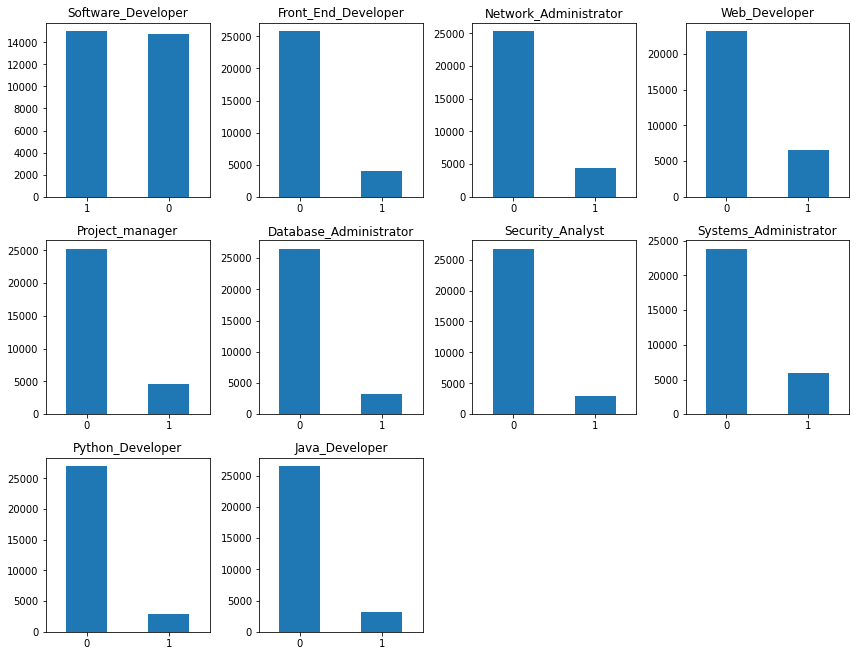

In [15]:
classes = ['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']

# for label in classes:
#     print(df[label].value_counts())
    
import math
from matplotlib import pyplot as plt

size = math.ceil(df_raw.shape[1]** (1/2))
fig = plt.figure(figsize=(12, 12))
# plt.figure(figsize=(10, 10))

for i, col in enumerate(classes):
    fig.add_subplot(size, size, i + 1)
    df_raw[col].value_counts().plot(kind="bar", ax=plt.gca(), title=col, rot=0)

fig.tight_layout()

In [16]:
df_raw['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']].values.tolist()

In [17]:
df = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']]
df['target_list'] = df_raw[['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']].values.tolist()
df['Text'] = df_raw['Text']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


In [ ]:
# df['RolesSkills'] = [''.join(l) for l in df_raw['Roles_Skills']]
# df['RolesSkills'] = df_raw['Roles_Skills'].apply(eval).apply(' '.join)
# # df['RolesSkills'] = df_raw['Roles_Skills'].apply(lambda x: ''.join(x))
# df['Skills+Experience'] = df['RolesSkills']+" "+df_raw['Experience']
# df['Experience']=df_raw['Experience']

In [18]:
df

,Software_Developer,Front_End_Developer,Network_Administrator,Web_Developer,Project_manager,Database_Administrator,Security_Analyst,Systems_Administrator,Python_Developer,Java_Developer,target_list,Text
0,1,1,0,0,0,0,0,0,0,0,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]",Front End Developer Front End Developer Front ...
1,0,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]",Systems Engineer Systems Engineer Systems Engi...
2,1,0,0,0,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",Java Developer Java Developer Java Developer -...
3,0,0,1,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",Telecommunications Technician Telecommunicatio...
4,1,0,0,0,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",Full Stack Developer Full Stack Developer Full...
...,...,...,...,...,...,...,...,...,...,...,...,...
29775,0,0,1,0,0,0,0,0,0,0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",NETWORK ADMINISTRATOR NETWORK ADMINISTRATOR NE...
29776,1,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Manager Manager Manager - Technology Specialis...
29777,1,0,0,0,0,0,0,0,0,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]",Mule ESB Developer Mule ESB Developer Mule ESB...
29778,0,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",Technology Liaison Analyst Technology Liaison ...


In [ ]:
# df['WORD_COUNT'] = df['Experience'].apply(lambda x: len(x.split()))

In [ ]:
# df_raw.hist('WORD_COUNT', bins=30)

In [19]:
df2 = df[['Text', 'target_list']].copy()
df2['Text'][1]

'Systems Engineer Systems Engineer Systems Engineer Long Beach CA Work Experience Systems Engineer Shlemmer Algaze Associates - Culver City CA March 2014 to Present Office 365 Hybrid Deployment Exchange Online migration WSUS design and implementation Hyper-V Host configuration and VM Build deploy maintain application servers Develop and deploy DR and Backup plan Migrate storage platform from traditional on premise storage to hybrid cloud Interface with vendors for present and potential products and services Troubleshoot and Deploy Windows 7 and 10 workstations using WDS Deskside support for end users Account Administrator Vaco Technology Services July 2011 to Present Support for 5000 end user environment Run reports and audit access rights user accounts and shares with the use of Hyena access enum and treesize pro Conduct interviews for employment candidates Interface with end-users management and resolve groups to appropriately facilitate the resolution of accounts  access rights Crea

In [20]:
df2

,Text,target_list
0,Front End Developer Front End Developer Front ...,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Systems Engineer Systems Engineer Systems Engi...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]"
2,Java Developer Java Developer Java Developer -...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,Telecommunications Technician Telecommunicatio...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,Full Stack Developer Full Stack Developer Full...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
...,...,...
29775,NETWORK ADMINISTRATOR NETWORK ADMINISTRATOR NE...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
29776,Manager Manager Manager - Technology Specialis...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
29777,Mule ESB Developer Mule ESB Developer Mule ESB...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
29778,Technology Liaison Analyst Technology Liaison ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
# # Sections of config

# # Defining some key variables that will be used later on in the training
# MAX_LEN = 256
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 4
# LEARNING_RATE = 1e-05

# import torch
# from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
# # model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# # inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
# # with torch.no_grad():
# #     logits = model(**inputs).logits

# # predicted_class_id = logits.argmax().item()
# # model.config.id2label[predicted_class_id]

# # tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [23]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['Text']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [24]:
train_size = 0.8
train_dataset = df2.sample(frac=train_size,random_state=200)
valid_dataset = df2.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df2.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

FULL Dataset: (29780, 2)
TRAIN Dataset: (23824, 2)
TEST Dataset: (5956, 2)


In [25]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [26]:
len(training_loader)

745

In [27]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
#         self.l1 = transformers.DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 10)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [28]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [29]:
len(training_loader)

745

In [30]:
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [31]:
import shutil, sys   
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    f_path = checkpoint_path
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(f_path, best_fpath)

In [32]:
#to use as global variables
val_targets=[]
val_outputs=[] 

In [33]:
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer, checkpoint_path, best_model_path):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [34]:
checkpoint_path = '/kaggle/working/current_checkpoint.pt'
best_model = '/kaggle/working/best_model.pt'
trained_model = train_model(1, 5, np.Inf, training_loader, validation_loader, model, optimizer, checkpoint_path, best_model)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000357 	Average Validation Loss: 0.000884
Validation loss decreased (inf --> 0.000884).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000209 	Average Validation Loss: 0.000749
Validation loss decreased (0.000884 --> 0.000749).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [35]:
val_preds = (np.array(val_outputs) > 0.5).astype(int)
val_preds

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0]])

In [36]:
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6679650772330423
F1 Score (Micro) = 0.8680568815637405
F1 Score (Macro) = 0.8514165468874537


In [37]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report

In [38]:
cm_labels = ['Software_Developer', 'Front_End_Developer',
       'Network_Administrator', 'Web_Developer', 'Project_manager',
       'Database_Administrator', 'Security_Analyst', 'Systems_Administrator',
       'Python_Developer', 'Java_Developer']
    
cm = mcm(val_targets, val_preds)

In [39]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.97      0.94      0.96     14980
           1       0.92      0.82      0.87      4010
           2       0.89      0.67      0.76      4555
           3       0.84      0.72      0.77      6690
           4       0.92      0.79      0.85      4390
           5       0.95      0.80      0.87      3235
           6       0.89      0.81      0.85      2960
           7       0.93      0.75      0.83      6045
           8       0.96      0.87      0.91      2730
           9       0.89      0.81      0.85      3180

   micro avg       0.92      0.82      0.87     52775
   macro avg       0.91      0.80      0.85     52775
weighted avg       0.92      0.82      0.87     52775
 samples avg       0.90      0.83      0.84     52775



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

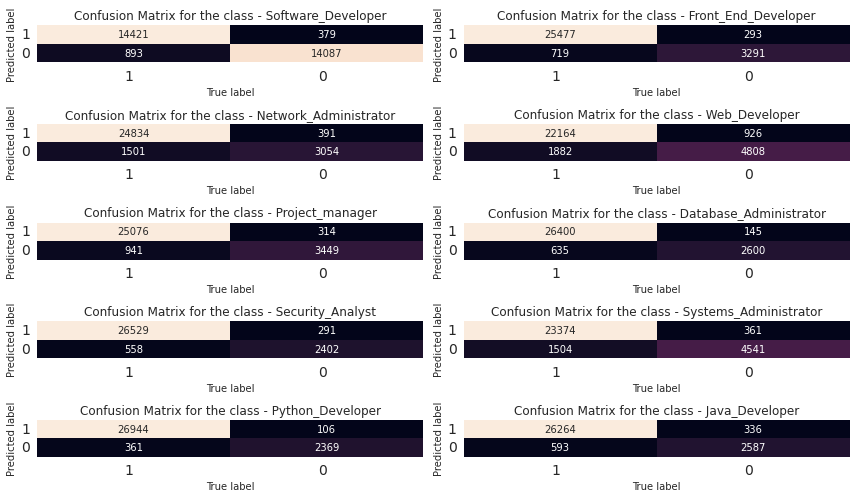

In [41]:
#print_confusion_matrix(mcm(targets, val_preds),class_label=labels, class_names=labels)
sns.set_style("whitegrid")
fig, ax = plt.subplots(5, 2, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), cm, cm_labels):
  print_confusion_matrix(cfs_matrix, axes, label, ["1", "0"])
    
fig.tight_layout()
plt.show()